# DS3000 Day 15

Nov 18/19, 2024

Admin
- Homework 4 due **Tomorrow/Today, Nov. 19**
- Lab 4 will be **Wed/Thur, Nov. 20/21**
- Phase III of the project due **Friday, Nov. 22** (Group submission to Gradescope, see ProjectGuidelines on Canvas)

Push-Up Tracker
- Section 03: 8
- Section 05: 10

Content:
- Continue Gradient Descent
- Basic Feed Forward Neural Networks

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
import math

## Previously: Simple Linear Perceptron?

An algorithm which estimates one of two classes (a binary classifier) defined by the **weight vector** $\vec{w}$.

**Example**:

Try to classify if someone **has** ($y = 1$) or **has not** ($y = -1$) done their co-op based on **age in months** ($x_1$) and **work hours** ($x_2$). The idea is, given a **new student** who we can measure $x_1$ and $x_2$ for, we can predict $y$ (are they more similar to students that have or have not done their co-op)?

To predict a new data point/observation, we would:

- take the dot product of the data vector $\vec{x}$ (including a bias term) and a **weight vector** $\vec{w}$
- use an **activation function** to predict the class label, $\hat{y}$

In this simples case, we'll use the **heaviside** activation function:

$$\hat{y} = \begin{cases} 
      1 & \vec{x}^T\vec{w} \geq 0 \\
      -1 & \text{else} 
   \end{cases}$$

The weight vector, $\vec{w}$, defines a **decision boundary**: in the simplest example we'll be doing, it is a line in (in this example) 2-dimensional ($\vec{x}_1$-$\vec{x}_2$) space on which one side of the points will be classified as 1 (Co-op) and the other -1 (No Co-op). How does the weight vector define the decision boundary?

$$\vec{x}^T\vec{w} = \begin{bmatrix}
    1 & x_1 & x_2
\end{bmatrix} \begin{bmatrix}
    w_0 \\ w_1 \\ w_2
\end{bmatrix} = 1(w_0) + x_1(w_1) + x_2(w_2) = 0 \rightarrow x_2 = -\frac{w_0}{w_2} - \frac{w_1}{w_2}x_1 $$

Notice, this is (in fact) the equation for a line; not one that passes best through the points, but one which ensures that the class labels are on opposite sides of the line (if possible).

### You may note, we don't know what $\vec{w}$ is

And, unlike in regression where there is an analytical solution to the coefficients of the line, we don't have that here. Instead, we will use the **gradient descent algorithm**, which requires us to (for classification):
- **initialize** the $\vec{w}$ vector
  - can be initialized as anything, but usually good practice to take a best guess to speed up computation time
- define the **activation function** and **loss function** (more on these later)
- loop through all data points/observations and iteratively:
  - update $\vec{w}$ if the observation is misclassified
  - until all points are either correctly classified or you have reached some other stopping criteriaa

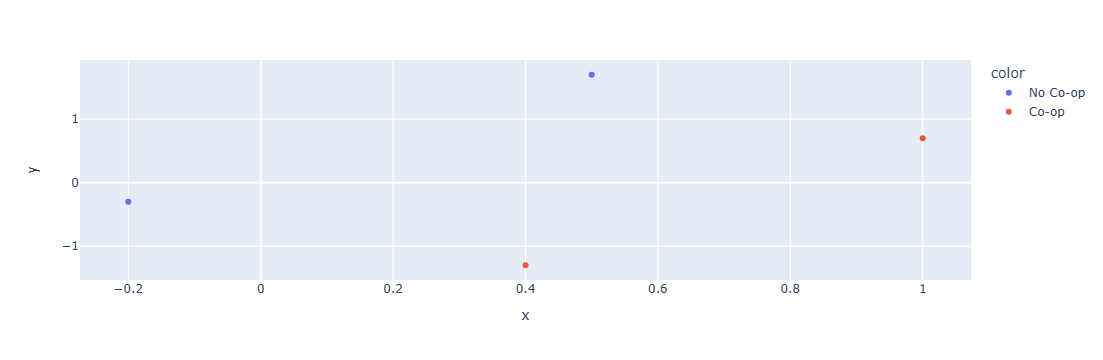

In [2]:
x1 = np.array([.5, 1, -.2, .4])
x2 = np.array([1.7, .7, -.3, -1.3])
text_y = ['No Co-op', 'Co-op', 'No Co-op', 'Co-op']
# we'll eventually want to sign numbers to these
#y = np.array([-1, 1, -1, 1])

px.scatter(x=x1, y=x2, color=text_y)

In [3]:
w = np.array([1, 1, 1])
X = np.concatenate([np.ones(4).reshape(-1,1), 
                    x1.reshape(-1,1), 
                    x2.reshape(-1,1)], axis = 1)
print(X)
y = [1 if student == "Co-op" else -1 for student in text_y]

[[ 1.   0.5  1.7]
 [ 1.   1.   0.7]
 [ 1.  -0.2 -0.3]
 [ 1.   0.4 -1.3]]


In [4]:
print(f'The w vector is: {w}')
print(f'This means the line is: x_2 = {-(w[0]/w[2]).round(2)} + {-(w[1]/w[2]).round(2)}x_1')

The w vector is: [1 1 1]
This means the line is: x_2 = -1.0 + -1.0x_1


In [5]:
# with the new w
for i in range(X.shape[0]):
    print(f'The dot product of observation {i} is {np.dot(X[i,:], w).round(2)} and y is {y[i]}. \n Is the observation correctly classified?: {np.dot(X[i,:], w) * y[i] >= 0}')

The dot product of observation 0 is 3.2 and y is -1. 
 Is the observation correctly classified?: False
The dot product of observation 1 is 2.7 and y is 1. 
 Is the observation correctly classified?: True
The dot product of observation 2 is 0.5 and y is -1. 
 Is the observation correctly classified?: False
The dot product of observation 3 is 0.1 and y is 1. 
 Is the observation correctly classified?: True


**SO:** How do we train the model? Enter the **loss function** and the **gradient**. 

The update of $\vec{w}$: $\vec{w}' = \vec{w} \pm \vec{x}$ comes from a specified **loss function** (i.e. how we want to measure prediction accuracy). In this case, the **Hinge Loss** function:

$$L(\vec{w}) = \max(0, -y_i\vec{x}^T\vec{w})$$

In other words, if the point $i$ is correctly classified, it's loss is 0 (good!) if it is incorrectly classified, the loss is some larger value. Notice that the update of $\vec{w}$ involves the derivative (the **gradient**) of the loss function being subtracted (**descending from**) to the previous value of $\vec{w}$:

$$\frac{\partial L}{\partial \vec{w}} = \begin{cases} 
      0 & L(\vec{w}) = 0  \text{ (correctly classified; } y_i = \hat{y}_i \text{)}\\
      -y_i\vec{x} & L(\vec{w}) > 0 \text{ (misclassified; } y_i \neq \hat{y}_i \text{)} 
   \end{cases}$$

$$\vec{w}' = \vec{w} - \frac{\partial L}{\partial \vec{w}}$$

So, for any given observation, at any point in the algorithm, there are four possibilities:

- if $y_i = 1$ and $\hat{y}_i = 1$, no need to update $\vec{w}$ (or, $\vec{w}' = \vec{w} - 0$)
- if $y_i = 1$ and $\hat{y}_i = -1$, need to update $\vec{w}' = \vec{w} - (-1)\vec{x} = \vec{w} + \vec{x}$)
- if $y_i = -1$ and $\hat{y}_i = -1$, no need to update $\vec{w}$ (or, $\vec{w}' = \vec{w} - 0$)
- if $y_i = -1$ and $\hat{y}_i = 1$, need to update $\vec{w}' = \vec{w} - (1)\vec{x}$)

### The Simple Linear Perceptron Gradient Descent Algorithm

1. Choose starting $\vec{w}$ arbitrarily (or with a best guess)
2. For each observation $i$ with $\vec{x}_i$ and label $y_i$:
    1. Estimate/predict the class of $i$ using $\vec{w}$:

        $$\hat{y}_i = \vec{x}^T\vec{w} \geq 0$$

    2. Update (or don't) $\vec{w}$:

        $$\vec{w}' = \vec{w} - \alpha\frac{\partial L}{\partial \vec{w}}$$
        
3. After looping through all observations, return to the first observation and loop again until all $\vec{x}$ are correctly classified.

Notice we've added yet another thing; what's $\alpha$ here? We call it the **learning rate**, which we might need to adjust if the algorithm is not converging. In this class, we usually default this value to 1 (i.e. ignore it), though it can be very helpful to set it to smaller values. In this class, unless I tell you to specify it as something other than 1, simply ignore it.

In [6]:
# using sci-kit learn's SGDClassifier function (check the docs, linked above, for details)
from sklearn.linear_model import SGDClassifier

# Initialize the SGDClassifier (since we added a bias term ourselves, no need to fit intercept)
# heaviside activation/modified hinge loss with learning rate of .01
perceptron = SGDClassifier(loss='hinge', max_iter=1000, random_state=42, 
                           fit_intercept = False, alpha = .01, shuffle = False)

# Train the Perceptron
perceptron.fit(X, y)

# Predicting the labels
print(perceptron.predict(X))
print(y)
fin_w = perceptron.coef_[0]
print(f'The w vector is: {fin_w}') #print final w vector
print(f'The final line is: x_2 = {-(fin_w[0]/fin_w[2]).round(2)} + {-(fin_w[1]/fin_w[2]).round(2)}x_1')

[-1  1 -1  1]
[-1, 1, -1, 1]
The w vector is: [-1.50098818  3.75247044 -1.05069172]
The final line is: x_2 = -1.43 + 3.57x_1


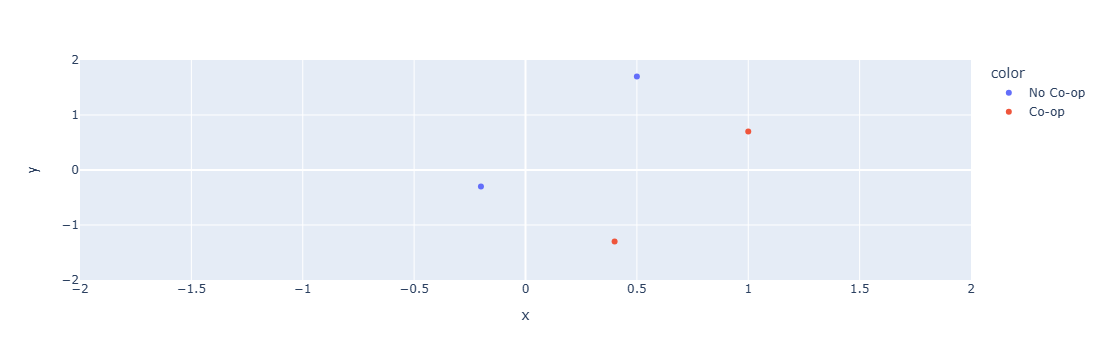

In [7]:
x1 = np.array([.5, 1, -.2, .4])
x2 = np.array([1.7, .7, -.3, -1.3])
text_y = ['No Co-op', 'Co-op', 'No Co-op', 'Co-op']

fig = px.scatter(x=x1, y=x2, color=text_y)
fig.update_xaxes(range=[-2,2])
fig.update_yaxes(range=[-2,2], autorange=False)

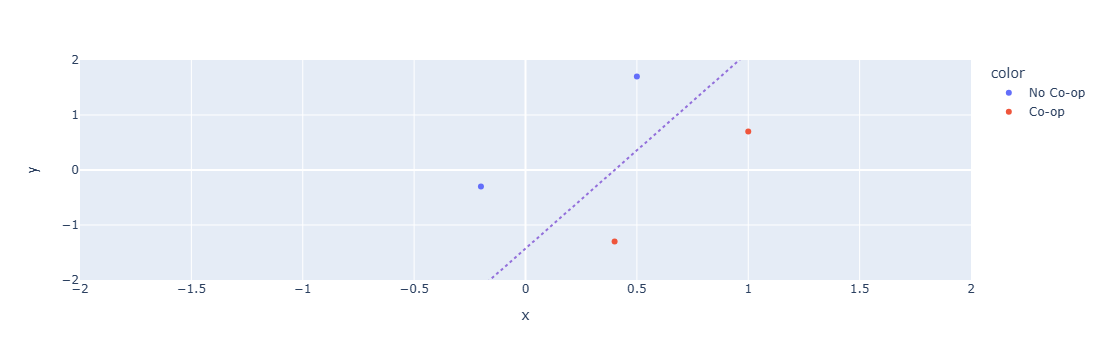

In [8]:
xlim = -1, 1
fig.add_shape(type="line",
    x0=xlim[0], y0=-(fin_w[0]/fin_w[2]) - (fin_w[1]/fin_w[2])*xlim[0], 
              x1=xlim[1], y1=-(fin_w[0]/fin_w[2]) - (fin_w[1]/fin_w[2])*xlim[1],
    line=dict(
        color="MediumPurple",
        width=2,
        dash="dot",
    ))
fig.show()

## Reminders:

- the only way our **simple** perceptron algorithm stops training (no matter what $\alpha$ is, though we may also need to adjust $\alpha$) is if the data are **linearly separable** (i.e. if a line can perfectly separate the classes)
- most of the time, data are **not** linearly separable. In such a case, we usually define some stopping criteria. Some examples might be running a maximum number of iterations, or to adjust the loss function by setting a different value than 0 for the "no update" step. For example, you could make the loss function:

$$L(\vec{w}) = \max(0.01, -y_i\vec{x}^T\vec{w})$$

Which would allow the algorithm to stop even when there is not perfect classification. This is one example of something called setting the **tolerance** (scikit-learn does it in a slightly different way than above).
- you don't have to do a perceptron in only two dimensions; you could do it in any number!
  - and you want to make sure the $x$ features are **standardized**
- the key assumption of all perceptrons are that the decision boundary is appropriate for the data
  - in the simple case, simply that the data are linearly separable, but even if they aren't, we make assumptions about the shape of the boundary based on the activation function
- in Gradient Descent, certain activation functions are only appropriate for certain types of data (same for certain loss functions as well).
- since the gradient descent algorithm is iterative, understanding your stopping criteria and making sure it makes sense is important
- evaluating the performance of the model via **cross validation** is still important too!

The fully worked (using scikit-learn; you will code your own linear perceptron on the Lab next class) example with the penguins:

In [9]:
# bring back our old friends, the penguins
df_penguins = sns.load_dataset('penguins')
# remove missing values
df_penguins.dropna(axis=0, inplace=True)
# standardize numeric columns
col_num_list = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
for feat in df_penguins.columns:
    if feat in col_num_list:
        df_penguins[f'{feat}'] = (df_penguins[feat] - df_penguins[feat].mean()) / df_penguins[feat].std()
df_penguins.head()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen       -0.894695       0.779559          -1.424608   
1  Adelie  Torgersen       -0.821552       0.119404          -1.067867   
2  Adelie  Torgersen       -0.675264       0.424091          -0.425733   
4  Adelie  Torgersen       -1.333559       1.084246          -0.568429   
5  Adelie  Torgersen       -0.858123       1.744400          -0.782474   

   body_mass_g     sex  
0    -0.567621    Male  
1    -0.505525  Female  
2    -1.188572  Female  
4    -0.940192  Female  
5    -0.691811    Male

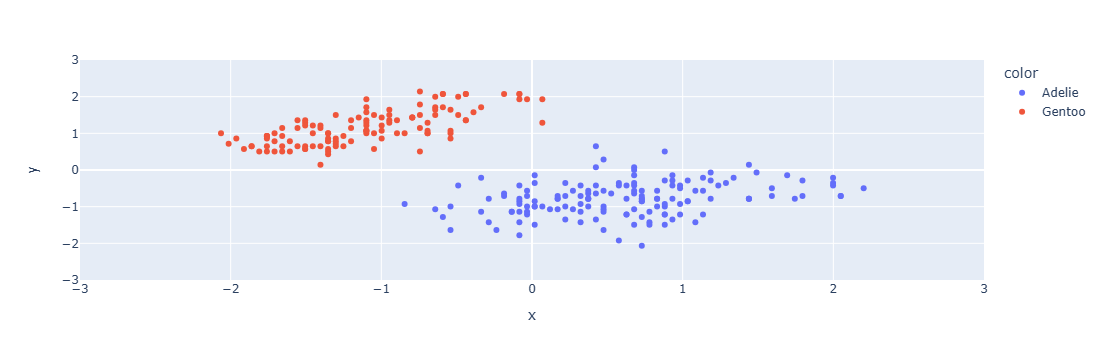

In [10]:
# let's try to predict if a species is Adelie or Gentoo
# based on their bill_depth and flipper_length
# subset the data first
bool_nochin = df_penguins.species != 'Chinstrap'
df_nochin = df_penguins.loc[bool_nochin,:]

# grab the bill_depth and flipper_length as x1 and x2
x1 = df_nochin.bill_depth_mm.to_numpy()
x2 = df_nochin.flipper_length_mm.to_numpy()

# grab the labels (first as text for plotting; we'll convert to -1 and 1 shortly)
text_y = df_nochin.species

xlim = -3, 3
fig = px.scatter(x=x1, y=x2, color=text_y)
fig.update_xaxes(range=xlim)
fig.update_yaxes(range=xlim, autorange=False)

Looking at this, we should be confident that there is at least SOME line that will separate the data! Let's do a few iterations of the first loop by hand, then use scikit-learn to finish the algorithm:

In [11]:
# convert the text_y to -1 and 1 for Adelie and Gentoo (respectively)
X = np.vstack([np.ones(len(x1)), x1, x2]).T # should print these X and y out to make sure they worked!
y = [1 if pen == "Gentoo" else -1 for pen in text_y]

In [12]:
# check to make sure they look right!
#X
#y

In [13]:
# initialize w to something we know doesn't work (for pedagogical reasons)
# I like this initialization since it corresponds to the line y=x with class -1
# above the line and class 1 below (or, I might have these switched? it shouldn't matter...)
w = np.array([0, 1, -1])
w

array([ 0,  1, -1])

In [14]:
# specify alpha (can experiment with changing this)
alpha = 1

# first observation check
# apply heaviside
print(np.dot(X[0,:], w))
# positive means class is 1, which is incorrect:
print(y[0])
# update
w = w - alpha*(-y[2]*X[2,:])
print(f'The new w vector is: {w}')
print(f'This means the line is: x_2 = {-(w[0]/w[2]).round(2)} + {-(w[1]/w[2]).round(2)}x_1')

2.2041666394260933
-1
The new w vector is: [-1.          0.57590895 -0.57426749]
This means the line is: x_2 = -1.74 + 1.0x_1


In [15]:
# second observation check
# apply heaviside
print(np.dot(X[1,:], w))
# negative means class is -1, which is correct:
print(y[1])
# NO need to update

-0.3179929659594646
-1


In [16]:
# third observation check
# apply heaviside
print(np.dot(X[2,:], w))
# negative means class is -1, which is correct:
print(y[2])
# NO need to update

-0.511277828445743
-1


In [17]:
# what if we loop until the next incorrectly specified observation?
# don't reset w, since we already "manually" did the first three obs, start with the fourth:
obs = 3
#we'll change the below runalg to False as soon as there's one update 
# (Hint for Lab: in the full algorithm, you would only change it to False 
# if you've done a full loop through the data and all the points are correctly classified)
runalg = True 
while runalg:
    x = X[obs, :]
    yhat = 1 if np.dot(x, w) >= 0 else -1

    if yhat == y[obs]:
        grad = 0
        print(f'Observation {obs+1} is correctly classified') #add one because python indexes at 0
    else:
        grad = -y[obs]*x
        print(f'The next observation to be updated is: {obs+1}')
        runalg = False

    w = w - alpha*grad
    obs += 1

print(f'The next update of w is: {w}, so the new line is: x_2 = {-(w[0]/w[2]).round(2)} + {-(w[1]/w[2]).round(2)}x_1')

Observation 4 is correctly classified
The next observation to be updated is: 5
The next update of w is: [-2.         -1.16849145  0.20820616], so the new line is: x_2 = 9.61 + 5.61x_1


We only had to wait a couple observations before updating again. Still, if it had been a better update, we might have had to wait a long time:

In [18]:
# now start with the 6th observation (never forget Python indexes at 0)
obs = 5
runalg = True 
while runalg:
    x = X[obs, :]
    yhat = 1 if np.dot(x, w) >= 0 else -1

    if yhat == y[obs]:
        grad = 0
        print(f'Observation {obs+1} is correctly classified') #add one because python indexes at 0
    else:
        grad = -y[obs]*x
        print(f'The next observation to be updated is: {obs+1}')
        runalg = False

    w = w - alpha*grad
    obs += 1

print(f'The next update of w is: {w}, so the new line is: x_2 = {-(w[0]/w[2]).round(2)} + {-(w[1]/w[2]).round(2)}x_1')

Observation 6 is correctly classified
Observation 7 is correctly classified
Observation 8 is correctly classified
Observation 9 is correctly classified
Observation 10 is correctly classified
Observation 11 is correctly classified
Observation 12 is correctly classified
Observation 13 is correctly classified
Observation 14 is correctly classified
Observation 15 is correctly classified
Observation 16 is correctly classified
Observation 17 is correctly classified
Observation 18 is correctly classified
Observation 19 is correctly classified
Observation 20 is correctly classified
Observation 21 is correctly classified
Observation 22 is correctly classified
Observation 23 is correctly classified
Observation 24 is correctly classified
Observation 25 is correctly classified
Observation 26 is correctly classified
Observation 27 is correctly classified
Observation 28 is correctly classified
Observation 29 is correctly classified
Observation 30 is correctly classified
Observation 31 is correctly c

Let's just finish it with scikit-learn (hopefully, though, you have some idea of what you're going to be doing on the Lab next class!)

In [19]:
# using sci-kit learn's SGDClassifier function (check the docs, linked above, for details)

# fitting on the full data set
# mess around with alpha and see how sometimes setting it smaller helps with convergence
# also, how do you do this if you DON'T pass scikit-learn an intercept column?
X_new = X[:,1:]
perceptron = SGDClassifier(loss='hinge', max_iter=1000, random_state=42, 
                           fit_intercept = True, alpha = .05, shuffle = False) # set fit_intercept to True

# Train the Perceptron
perceptron.fit(X_new, y)

# Predicting the labels
print(perceptron.predict(X_new))
print(y)
fin_w = np.concatenate([perceptron.intercept_, perceptron.coef_[0]])
print(fin_w) #print final w vector
print(f'The final line is: x_2 = {-(fin_w[0]/fin_w[2]).round(2)} + {-(fin_w[1]/fin_w[2]).round(2)}x_1')

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,

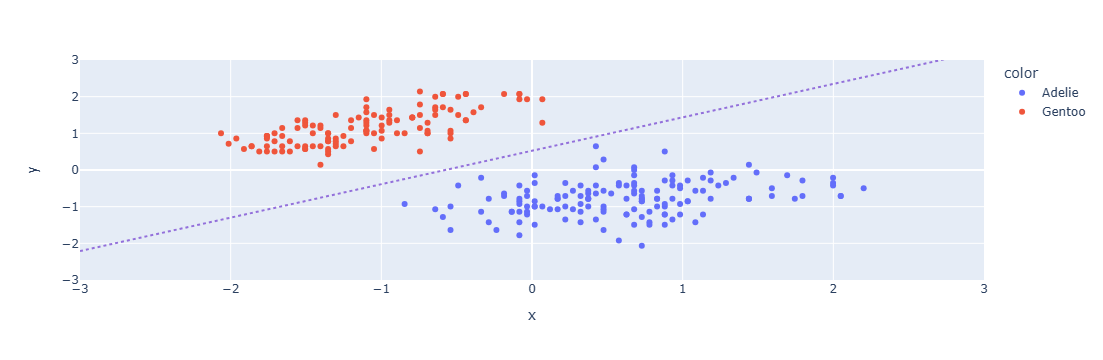

In [20]:
fig.add_shape(type="line",
    x0=xlim[0], y0=-(fin_w[0]/fin_w[2]) - (fin_w[1]/fin_w[2])*xlim[0], 
              x1=xlim[1], y1=-(fin_w[0]/fin_w[2]) - (fin_w[1]/fin_w[2])*xlim[1],
    line=dict(
        color="MediumPurple",
        width=2,
        dash="dot",
    ))
fig.show()

### Motivating Other Activation/Loss Functions

We started thinking about applying this to our Getting to Know You data and predicting whether a student has or has not done their co-op. Based on the plot below, can you explain why we ultimately didn't do this?

In [21]:
df_gtky = pd.read_csv('cleaner_gtky.csv')
df_gtky.dropna(axis=0, inplace=True)
gtky_percept = df_gtky.loc[:,['co_op', 'age_months', 'work_hours']]
col_num_list = ['age_months', 'work_hours']
for feat in gtky_percept.columns:
    if feat in col_num_list:
        gtky_percept[f'{feat}'] = (gtky_percept[feat] - gtky_percept[feat].mean()) / gtky_percept[feat].std()

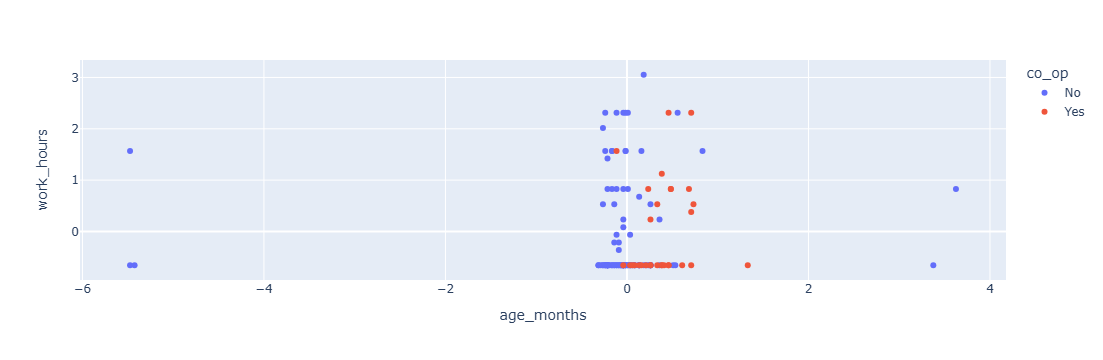

In [22]:
px.scatter(gtky_percept, x='age_months', y='work_hours', color='co_op')

### More Gradient Descent and Baby Neural Networks
#### Or: How Linear Regression and the Perceptron Are Both Neural Networks

Remember our error terms (residuals) in linear regression;

$$e_i = y_i - \hat{y}_i$$

They represent how close the points are to the line of best fit: 
$$\hat{y} = X\vec{b}$$

, or for an individual observation $$\hat{y}_i = \vec{x}_i^T\vec{b}$$

Notice that we find the prediction for the linear regression **the same way** we find the prediction for the linear perceptron; with the dot product of an observation's $\vec{x}$ and a weight vector! Remember that the function we use to ``link" the dot product to a 1 or $-1$ in the perceptron is called an **activation function**. Since linear regression is about predicting a number, it has the **identity function** as it's activation function.

Just like the linear perceptron, we can define a gradient descent algorithm which minimizes the **loss function** of the regression model. In this case, we define the loss function as something we've seen before, the mean squared error $MSE$:

$$L(\vec{b}) = \frac{1}{n} \sum_{i} e_i^2 = \frac{1}{n} \sum_{i} (y_i - \hat{y}_i)^2 = \frac{1}{n} \sum_{i} (y_i - \vec{x}_i^T\vec{b})^2$$

And so (using $u$-substitution) we can show that the gradient is:

$$\frac{\partial L(\vec{b})}{\partial \vec{b}} = \frac{-2}{n} \sum_{i} e_i\vec{x}_i$$

Or, for an individual $b$ (i.e. separating the intercept and slope(s)):

$$\frac{\partial L(b_0)}{\partial b_0} = \frac{-2}{n} \sum_{i} e_i$$
$$\frac{\partial L(b_k)}{\partial b_k} = \frac{-2}{n} \sum_{i} e_ix_{ik}$$

And we can use gradient descent to iteratively update both intercept and slope after each observation, just like the linear perceptron:

In [23]:
# the data simulation functions, stolen from Prof. Higger
def poly(x, coef):
    """ computes polynomials in x
    
    to represent the polynomial:
    
    b_0 x^0 + b_1 x^1 + b_2 x^2 + b_3 x^3 + ...
    
    coef = [b_0, b_1, b_2, b_3, ...]
    
    Args:
        x (np.array): input values
        coef (np.array): coefficients of polynomial
    """
    # initialize y as array of zeros
    y = np.zeros_like(x)
    
    # adds each monomial one at a time
    for deg, b in enumerate(coef):
        y += b * x ** deg
        
    return y 

def get_poly_data(coef, x_start=0, x_fin=10, n=101, noise=20, r_seed=0):
    np.random.seed(r_seed)
    x = np.linspace(x_start, x_fin, n)
    y = poly(x, coef) 
    
    # add some noise
    y = y + np.random.standard_normal(x.size) * noise
    
    # reshape into sklearn standard (n_samples, n_features)
    x = x.reshape(-1, 1)
    return x, y

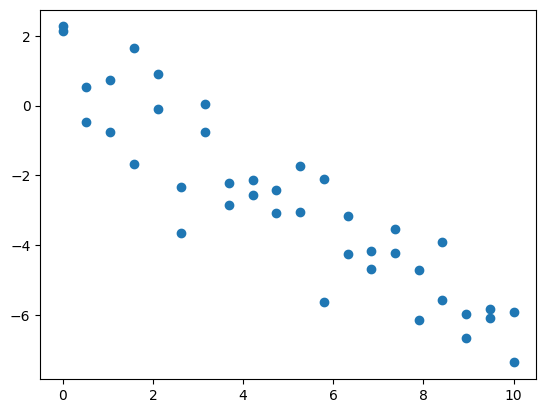

In [24]:
# this just simulates some data under the "true" line of y = .5 - .7x
true_b = np.array([.5, -.7])
Xa, ya = get_poly_data(true_b, n = 20, noise=1)
Xb, yb = get_poly_data(true_b, n = 20, noise=1, r_seed=1)
X = np.vstack((Xa, Xb))
y = np.concatenate([ya, yb])
plt.scatter(X, y);

Let's first plot the true relationship between $x$ and $y$ and then (instead of fitting the full line of best fit through our sample data), use gradient descent sequentially find the line of best fit using the data.

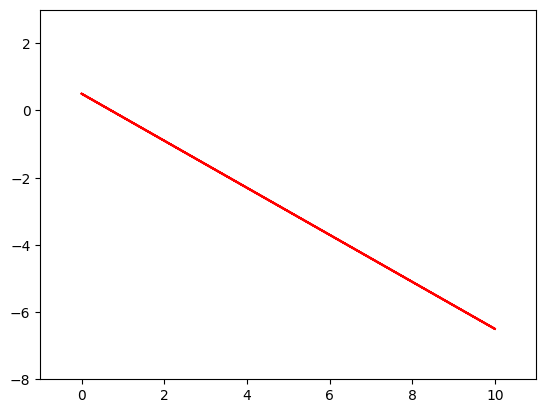

In [25]:
# Creating an empty scatter plot
plt.scatter([], [])

# Adding the true line
X_new = np.hstack((np.array([[1] * len(y)]).reshape(-1,1), X))
truey = np.matmul(X_new, true_b)
plt.plot(X, truey, '-r');
plt.xlim((-1, 11));
plt.ylim((-8, 3));

2.264052345967664
[ 0.11320262 -1.        ]


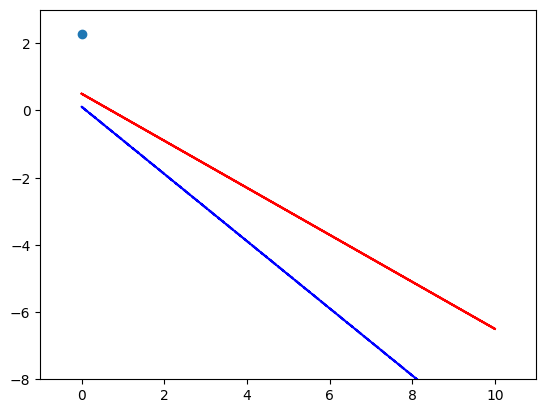

In [26]:
#initialize an intercept and slope
b_step = np.array([0.0, -1.0])

#get error for first point
e1 = y[0] - np.dot(b_step, X_new[0,:])
print(e1)

#get the gradient
grad1 = -(2/len(y)) * e1 * X_new[0,:]

#update b, use alpha of 1
b_step = b_step - 1 * grad1
print(b_step)

#visualize
plt.scatter(X[0,:], y[0])

# Adding the line from the first iteration
y_step = np.matmul(X_new, b_step)
plt.plot(X, truey, '-r');
plt.plot(X, y_step, '--b');
plt.xlim((-1, 11));
plt.ylim((-8, 3));

0.9448493279109453
[ 0.16044508 -0.97513554]


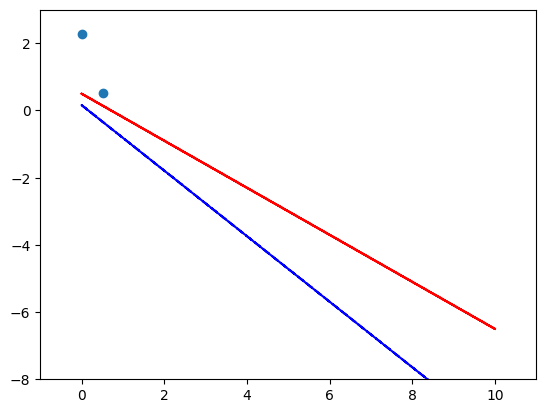

In [27]:
#second iteration
#get error for second point
e2 = y[1] - np.dot(b_step, X_new[1,:])
print(e2)

#get the gradient
grad2 = -(2/len(y)) * e2 * X_new[1,:]

#update b
b_step = b_step - 1 * grad2
print(b_step)

#visualize
plt.scatter(X[0:2,:], y[0:2])

# Adding the line from the first iteration
y_step = np.matmul(X_new, b_step)
plt.plot(X, truey, '-r');
plt.plot(X, y_step, '--b');
plt.xlim((-1, 11));
plt.ylim((-8, 3));

1.6079092625195388
[ 0.24084055 -0.89050874]


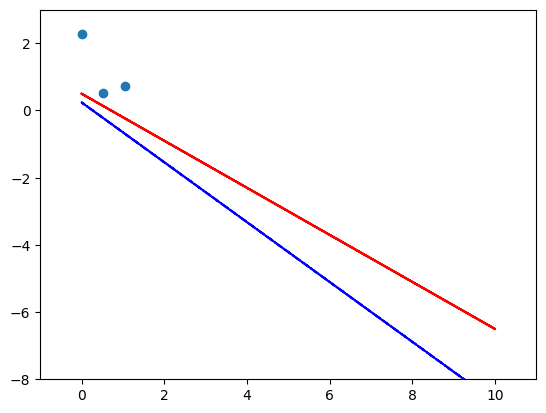

In [28]:
#third iteration
#get error for third point
e3 = y[2] - np.dot(b_step, X_new[2,:])
print(e3)

#get the gradient
grad3 = -(2/len(y)) * e3 * X_new[2,:]

#update b
b_step = b_step - 1 * grad3
print(b_step)

#visualize
plt.scatter(X[0:3,:], y[0:3])

# Adding the line from the first iteration
y_step = np.matmul(X_new, b_step)
plt.plot(X, truey, '-r');
plt.plot(X, y_step, '--b');
plt.xlim((-1, 11));
plt.ylim((-8, 3));

The updated b vector for iteration 1 is: [ 0.11320262 -1.        ]


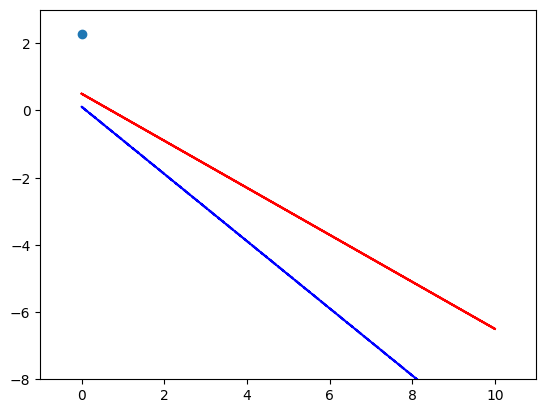

The updated b vector for iteration 2 is: [ 0.13682385 -0.98756777]


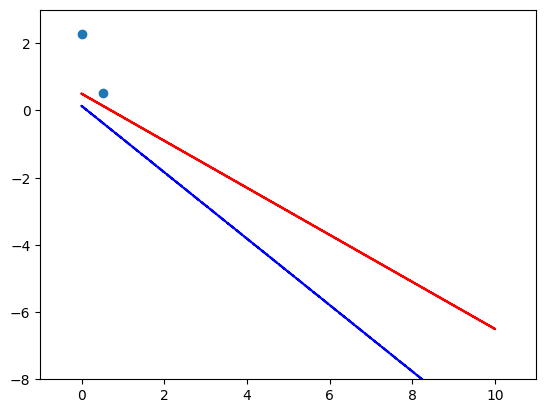

The updated b vector for iteration 3 is: [ 0.16423413 -0.95871484]


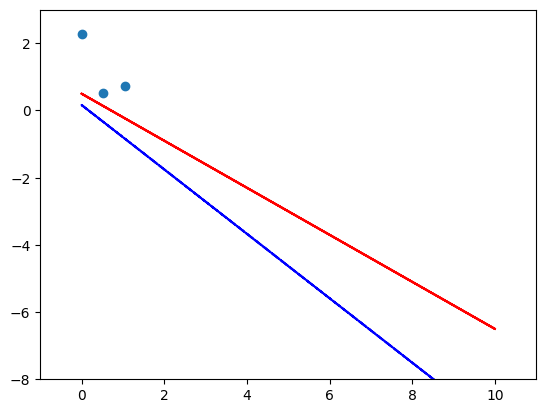

The updated b vector for iteration 4 is: [ 0.20154859 -0.89979729]


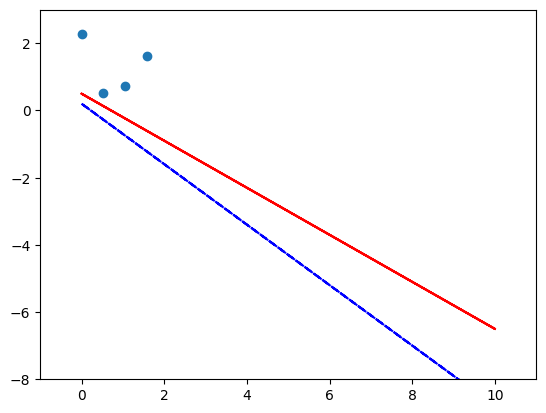

The updated b vector for iteration 5 is: [ 0.22741494 -0.84534181]


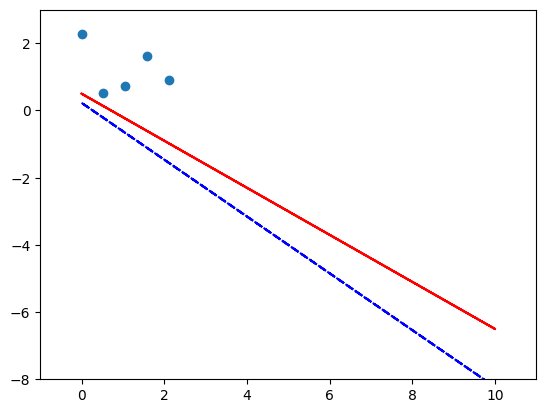

The updated b vector for iteration 6 is: [ 0.22472982 -0.85240791]


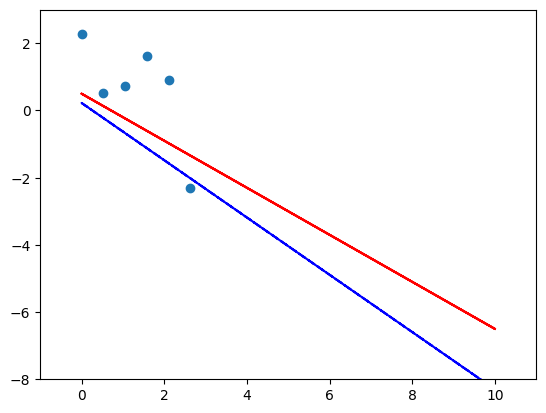

The updated b vector for iteration 7 is: [ 0.23692015 -0.81391212]


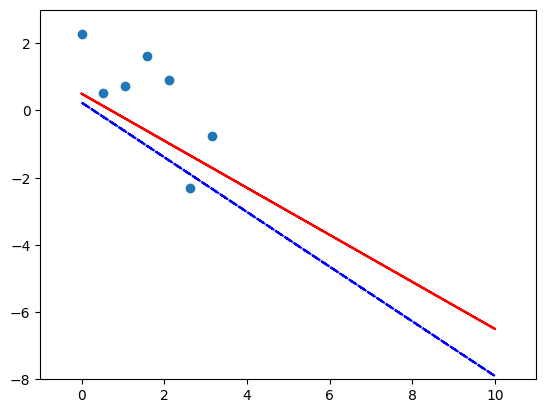

The updated b vector for iteration 8 is: [ 0.2402414  -0.80167596]


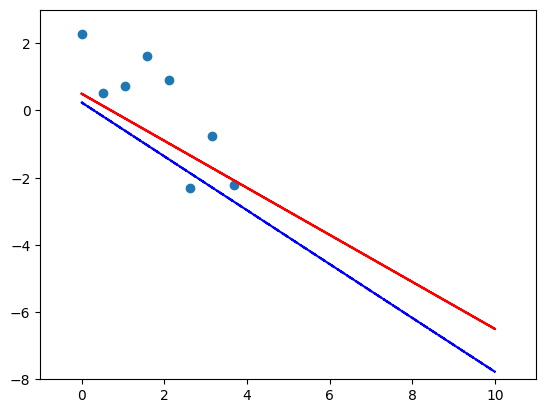

The updated b vector for iteration 9 is: [ 0.24348945 -0.78799996]


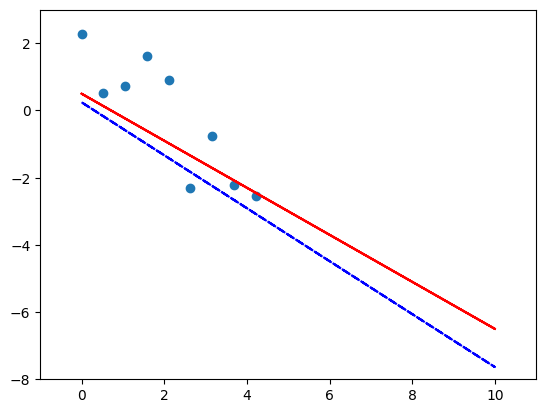

The updated b vector for iteration 10 is: [ 0.2489092  -0.76232744]


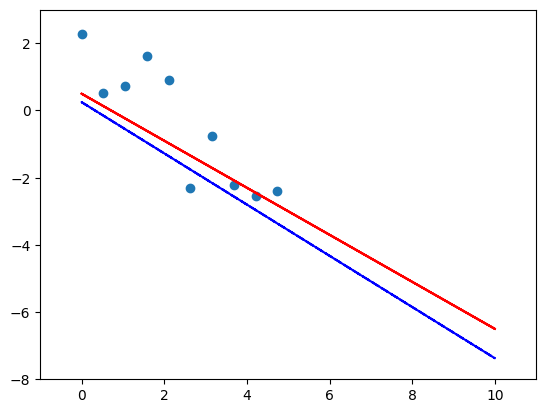

The updated b vector for iteration 11 is: [ 0.25219635 -0.74502664]


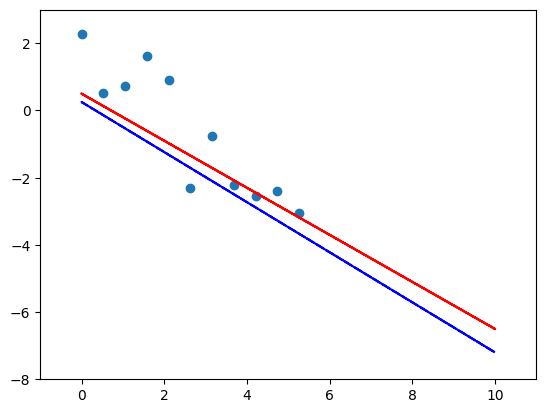

The updated b vector for iteration 12 is: [ 0.26037451 -0.69767941]


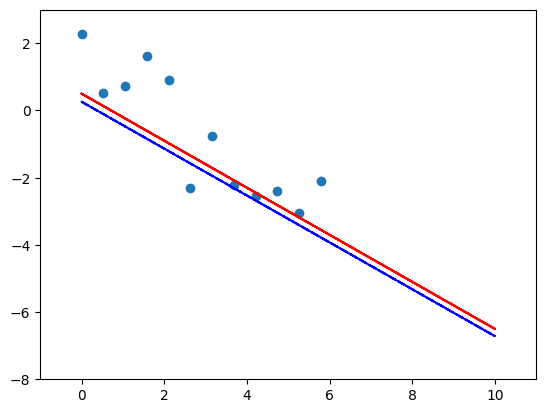

The updated b vector for iteration 13 is: [ 0.26416685 -0.67372783]


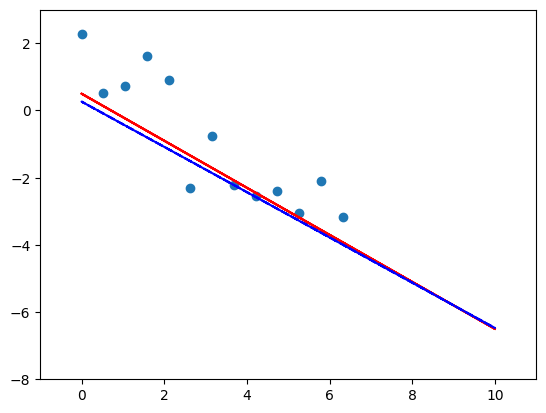

The updated b vector for iteration 14 is: [ 0.26480167 -0.66938428]


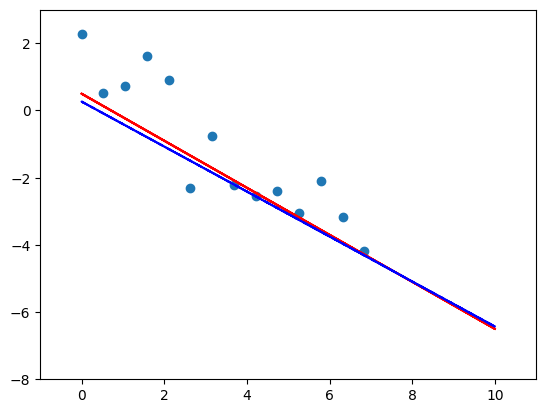

The updated b vector for iteration 15 is: [ 0.26631324 -0.65824637]


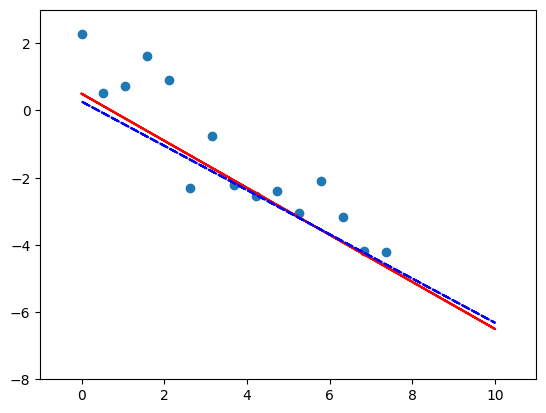

The updated b vector for iteration 16 is: [ 0.26705614 -0.65238139]


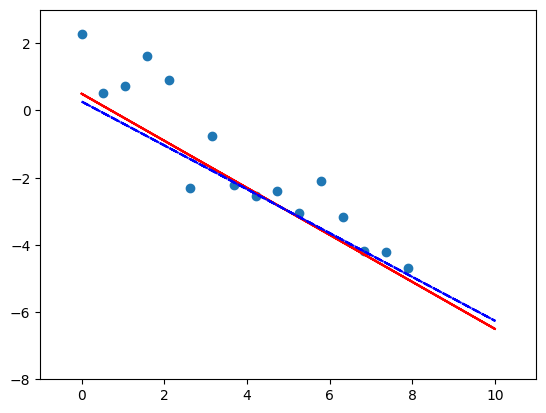

The updated b vector for iteration 17 is: [ 0.27095621 -0.61953869]


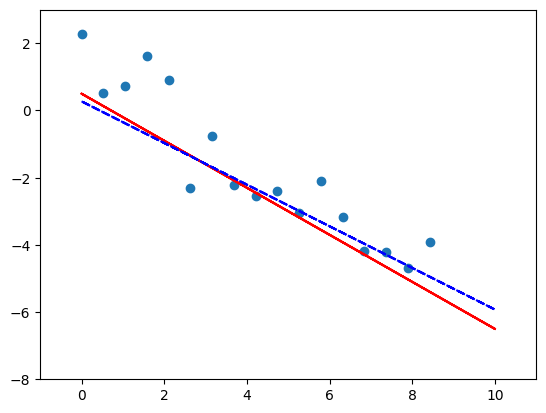

The updated b vector for iteration 18 is: [ 0.26902279 -0.63683772]


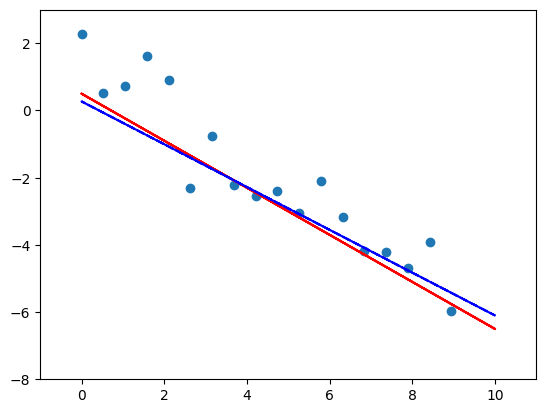

The updated b vector for iteration 19 is: [ 0.26887981 -0.63819232]


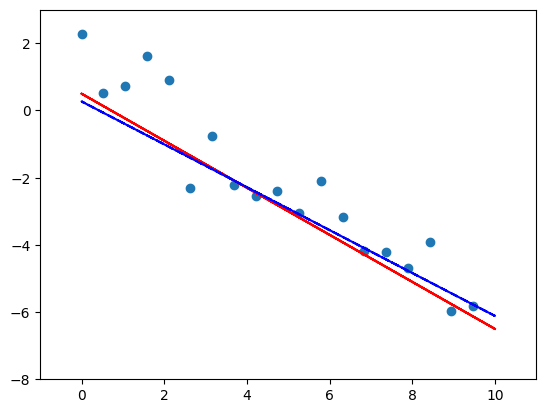

The updated b vector for iteration 20 is: [ 0.26577718 -0.66921863]


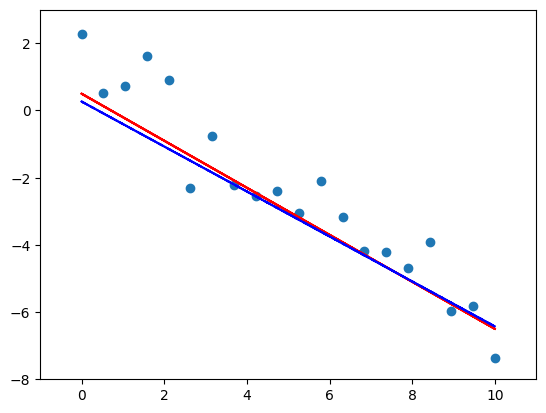

The updated b vector for iteration 21 is: [ 0.27020234 -0.66921863]


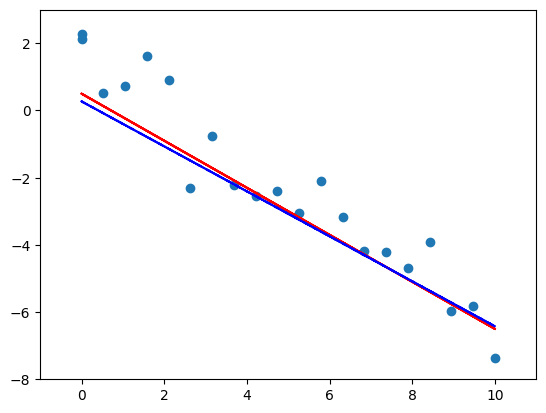

The updated b vector for iteration 22 is: [ 0.26929743 -0.6696949 ]


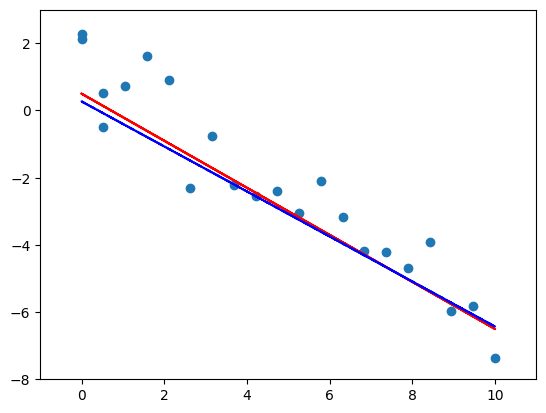

The updated b vector for iteration 23 is: [ 0.26858141 -0.6704486 ]


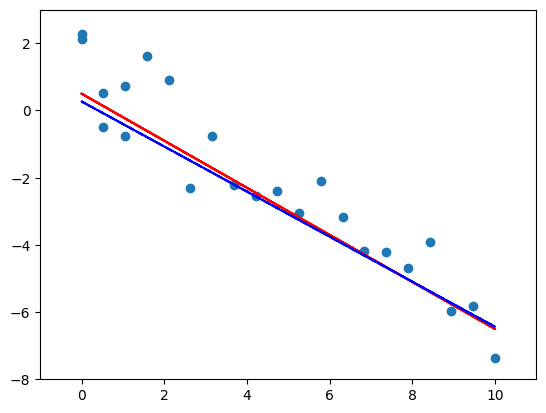

The updated b vector for iteration 24 is: [ 0.26673097 -0.67337035]


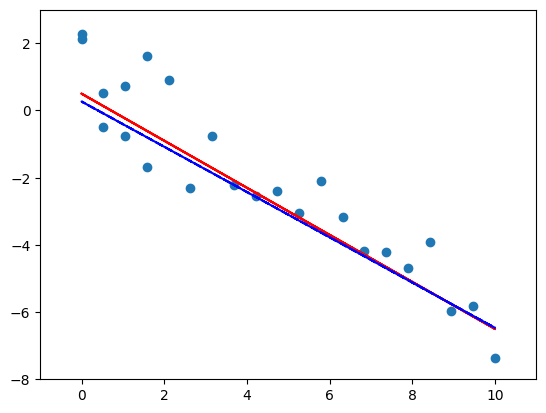

The updated b vector for iteration 25 is: [ 0.2688162  -0.66898039]


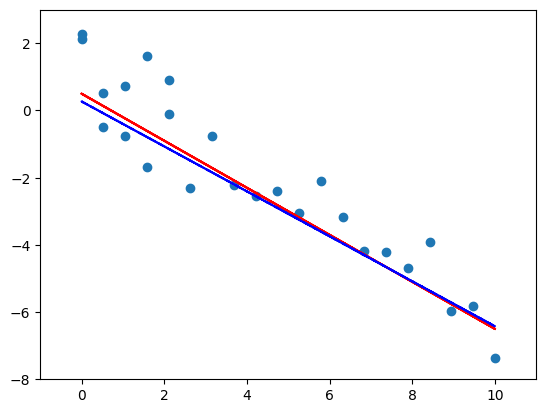

The updated b vector for iteration 26 is: [ 0.26467777 -0.67987101]


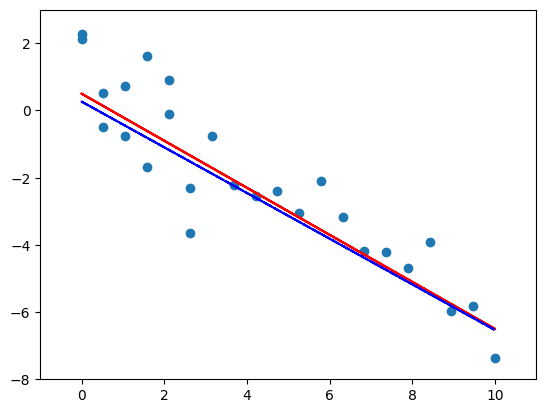

The updated b vector for iteration 27 is: [ 0.26822697 -0.668663  ]


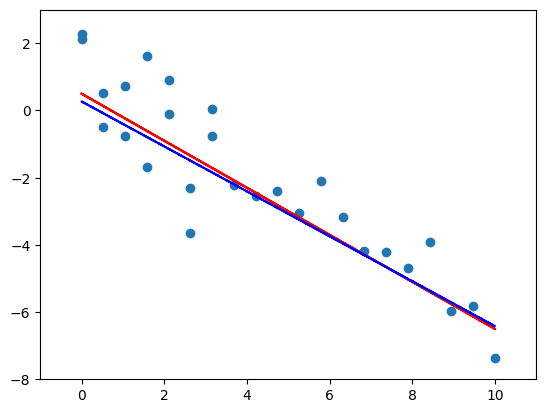

The updated b vector for iteration 28 is: [ 0.26707539 -0.67290567]


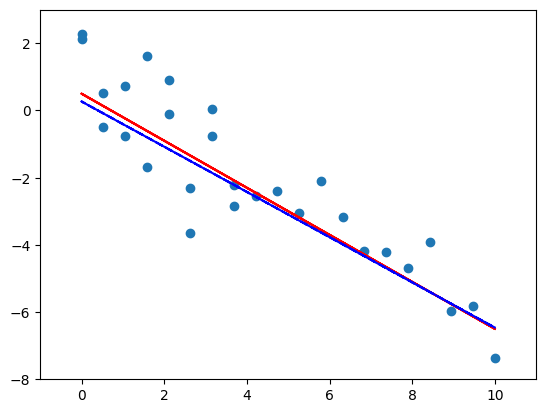

The updated b vector for iteration 29 is: [ 0.26783036 -0.66972685]


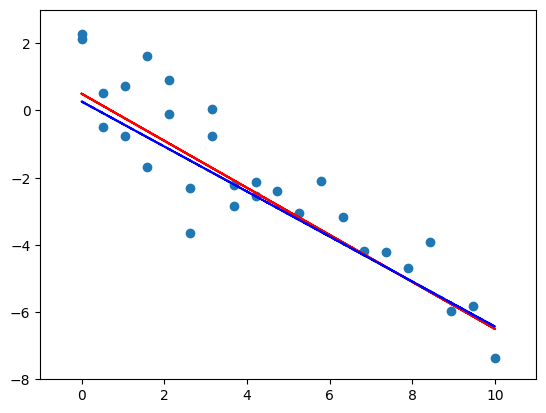

The updated b vector for iteration 30 is: [ 0.26756269 -0.67099475]


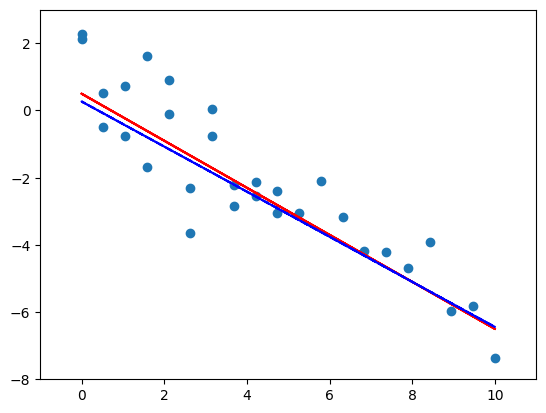

The updated b vector for iteration 31 is: [ 0.2700496  -0.65790573]


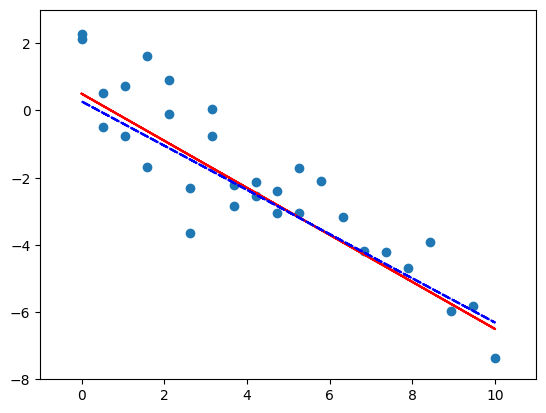

The updated b vector for iteration 32 is: [ 0.26680914 -0.67666628]


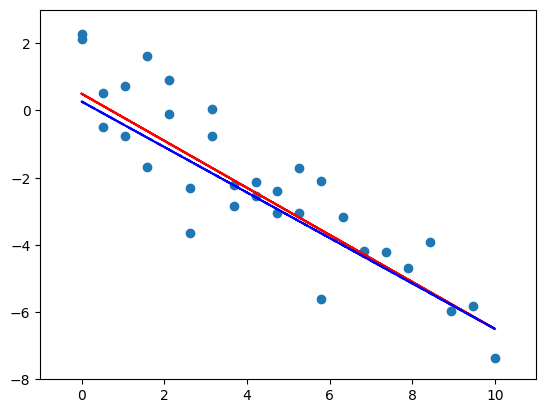

The updated b vector for iteration 33 is: [ 0.26645066 -0.67893037]


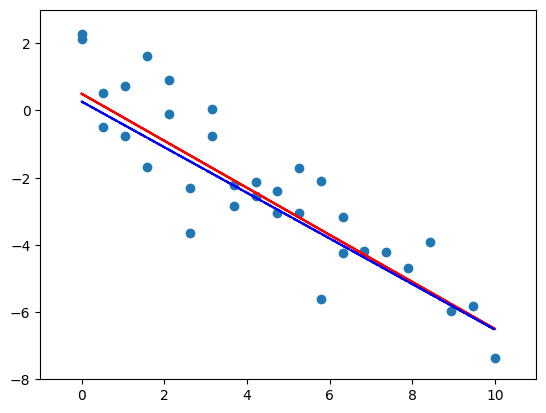

The updated b vector for iteration 34 is: [ 0.26601733 -0.68189527]


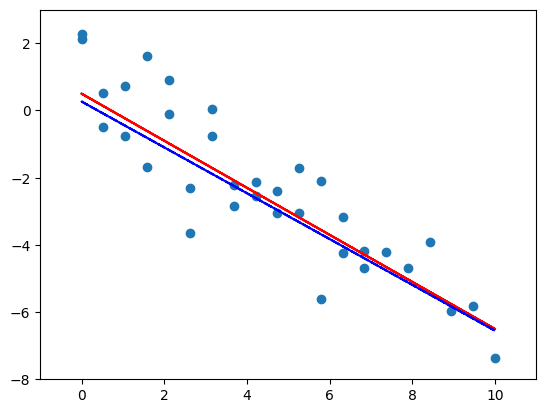

The updated b vector for iteration 35 is: [ 0.26778069 -0.66890213]


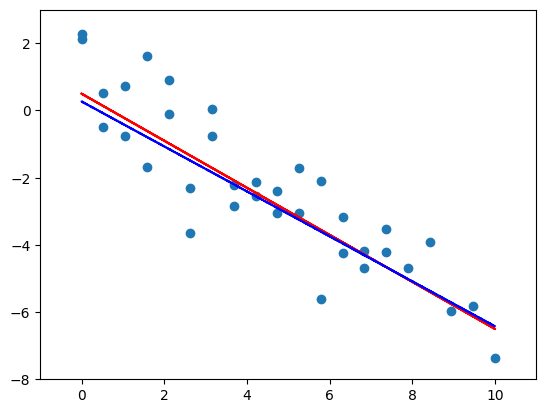

The updated b vector for iteration 36 is: [ 0.2662346  -0.68110807]


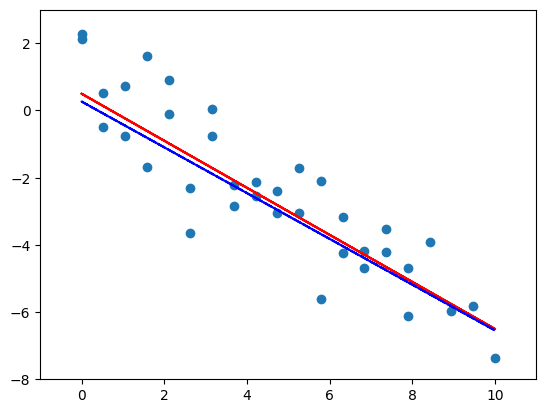

The updated b vector for iteration 37 is: [ 0.2661025  -0.68222047]


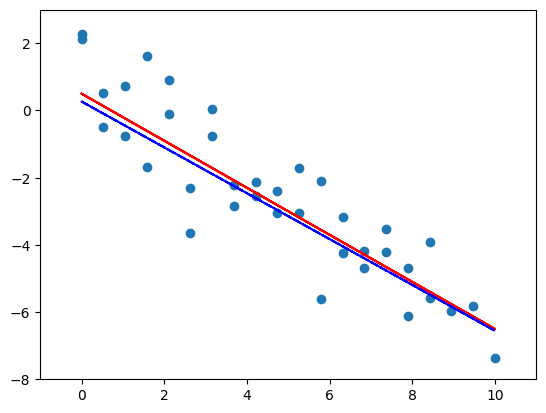

The updated b vector for iteration 38 is: [ 0.26504587 -0.69167456]


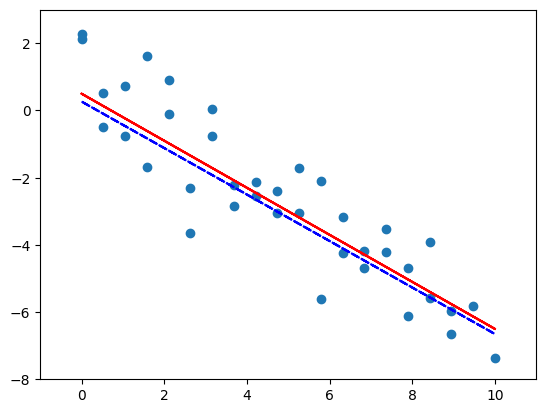

The updated b vector for iteration 39 is: [ 0.26530009 -0.68926611]


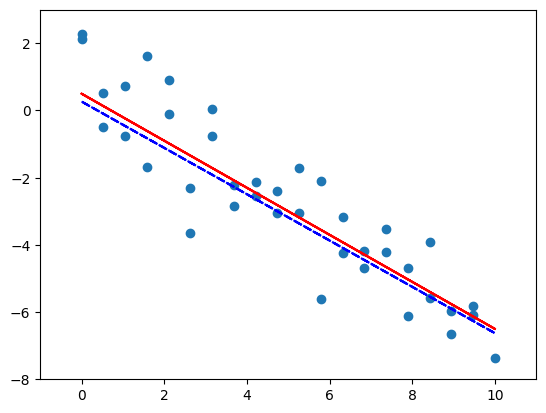

The updated b vector for iteration 40 is: [ 0.26618781 -0.68038891]


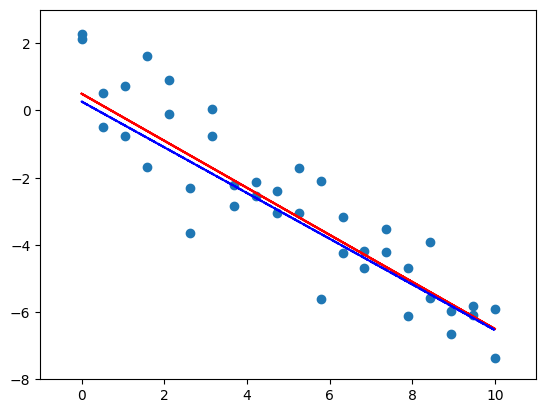

In [29]:
b_step = np.array([0.0, -1.0]) #initialize b vector
alpha = 1  # Define an initial learning rate

#loop for stochastic gradient descent
for obs in range(len(y)):
    #error
    e = y[obs] - np.dot(b_step, X_new[obs,:])

    #get the gradient
    grad = -(2/len(y)) * e * X_new[obs,:]

    #update b, use alpha of 1/iter
    #it is generally a good idea to decrease the learning rate as the algorithm goes
    #the idea is that the longer you go, the less drastic changes you need to make
    b_step = b_step - (alpha/(obs+1)) * grad
    print(f'The updated b vector for iteration {obs+1} is: {b_step}')

    #visualize
    plt.scatter(X[0:(obs+1),:], y[0:(obs+1)])

    # Adding the line from the first iteration
    y_step = np.matmul(X_new, b_step)
    plt.plot(X, truey, '-r');
    plt.plot(X, y_step, '--b');
    plt.xlim((-1, 11));
    plt.ylim((-8, 3));
    plt.show();


### Note
After looping through the points only once, we will not have necessarily converged to the line of best fit:

In [30]:
# the final b from gradient descent linear regression
b_step

array([ 0.26618781, -0.68038891])

In [31]:
# the line of best fit
np.matmul(np.linalg.inv(np.matmul(X_new.T, X_new)), np.matmul(X_new.T, y))

array([ 1.04173624, -0.76475025])

In [32]:
true_b

array([ 0.5, -0.7])

We can either loop through the data again (continuously, as in the linear perceptron, where we determine the number of iterations or some other stopping criterion) or implement a **batch** gradient descent, which does everything above but with the full data set at each iteration. However, there are two reasons why we would rarely (if ever) do this for a simple linear regression problem:

- the speed of convergence is heavily reliant on the starting value and the learning rate; without a carefully chosen learning rate, the algorithm may take a *long* time to get close to the line of best fit (or, just never converge!)
- we already *know* the **solution** to the line of best fit: $(X^TX)^{-1}X^Ty$
  - no reason to iterate when we can just find the solution!

### Thinking of these as Neural Networks

Both linear regression and the linear perceptron can be visualized as a single layer neural network (draw on the board) where each observation's output node ($y$) is predicted using the input nodes ($x$'s) and the weights ($b$'s, or $w$'s in the linear perceptron). In the two algorithms we've discussed, we have used two activation functions, the identity function for linear regression:

$$\hat{y}_i = f(x_i) = I(\vec{x}_i^T\vec{b})  =\vec{x}_i^T\vec{b}$$

And the step, or heaviside step function for the linear perceptron:

$$\hat{y}_i = f(x_i) = \begin{cases}
    1 & \text{ if } \vec{x}_i^T\vec{w} \geq 0 \\
    -1 & \text{ if } \vec{x}_i^T\vec{w} < 0
\end{cases}$$

One of the benefits of neural networks, however, is that we can extend these models and make them only slightly more complicated, but then allow for things like non-linear decision boundaries in the perceptron algorithm (for example). The two key ways we make neural networks more complex:

- Use different activation functions
- Add "hidden" layers

For example, if we wanted to output a "probability" of being 1 or -1 in the linear perceptron, we might use something like the **sigmoid** function as an activation function:

$$\hat{y}_i = f(x_i) = \frac{1}{1 + e^{-\vec{x}_i^T\vec{w}}}$$

However, with such an activation, we should update a couple things; first of all, instead of $-1$, we will call the other class $0$, and the loss function should then be updated as well. For example, the **Log Loss**:

$$L(\vec{w}) = -y_i \log(\hat{y}_i) - (1 - y_i) \log(1 - \hat{y}_i)$$

Which, with a little bit of work, gives us a gradient of:

$$\frac{\partial L(\vec{w})}{\partial \vec{w}} = (\hat{y}_i - y_i)\vec{x}$$

(I'll show this in an example at the end of the notebook and go over it if there's time).

### More complex neural networks

While I definitely don't have time to do this full justice, we can make neural networks even more interesting by adding more layers. Something like:

<a href="https://ibb.co/C1PyNMG"><img src="https://i.ibb.co/5MK3tnH/IMG-20231116-140427480.jpg" alt="IMG-20231116-140427480" border="0"></a>

Where you add a bunch of additional weights that are estimated by potentially specifying different activation functions for the hidden layer nodes (for example, in linear regression, while the final output node may still have the identity function as the activation function, we might select a range of potential activation functions for the hidden nodes to help with non-linearity or to account for interactions between the features).

For a silly, trivial example (**which you would never actually do in practice**) that can help understand how the "feed-forward" estimation works. Imagine we have simple identity activation functions for both the hidden and output layers, and define the loss function as the mean squared error for each layer. There can be as many hidden nodes as you like (call them $h_j$), where each input node ($x_i$) is used:

$$h_j = \vec{x}^T\vec{w}$$
$$\hat{y} = \vec{h}^T\vec{v}$$

1. Initialize $w_{jk}$'s and $v_j$'s arbitrarily or randomly
2. Update $w_{jk}$'s via gradient descent
    1. $w_{jk} \leftarrow w_{jk} - \alpha \frac{\partial L}{\partial w_{jk}} = w_{jk} - \alpha(-2 v_j x_k (y - \hat{y}))$
3. Update $v_j$'s via gradient descent
    1. $v_j \leftarrow v_j - \alpha \frac{\partial L}{\partial v_j} = v_j - \alpha(-2 h_j (y - \hat{y}))$
4. Move to the next observation; iterate until stopping criterion met

## Replacing the activation function for the linear perceptron

Let's re-do our first perceptron problem, but with a different activation (and loss) function:

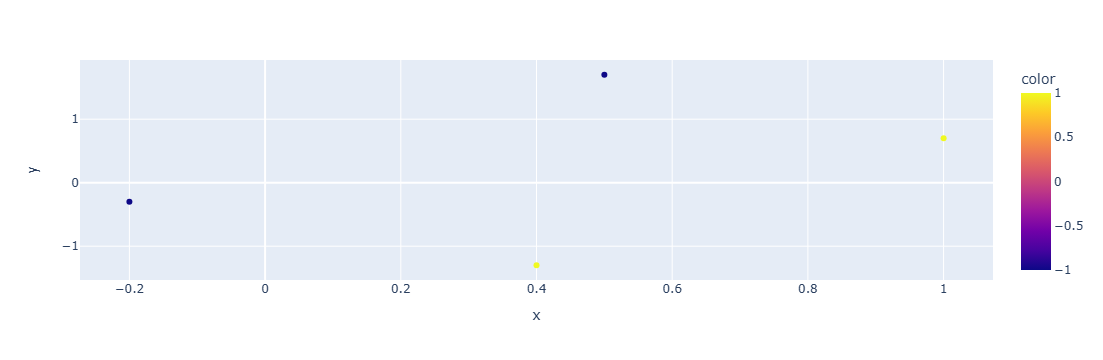

In [33]:
x1 = np.array([.5, 1, -.2, .4])
x2 = np.array([1.7, .7, -.3, -1.3])
y = np.array([-1, 1, -1, 1])
X = np.concatenate([np.ones(4).reshape(-1,1), 
                    x1.reshape(-1,1), 
                    x2.reshape(-1,1)], axis = 1)

px.scatter(x=x1, y=x2, color=y)

In [34]:
import math

# doing the algorithm "by hand"; the first iteration
w = np.array([0, -1, 1])
x1 = np.array(X[0,:])
x2 = np.array(X[1,:])
x3 = np.array(X[2,:])
x4 = np.array(X[3,:])
yi = np.array([0, 1, 0, 1])

#check x1 predictive probability (we will ALWAYS update, now, however)
yhat1 = 1/(1 + np.exp(-np.dot(x1, w))) #more than .5 implies more likely to be 0
yhat1
# subtract from 1 to see the probability y1=1
# 1 - yhat1

0.7685247834990175

In [35]:
# update w using gradient of log loss and alpha = 1
w = w - (yhat1 - yi[0])*x1
w

array([-0.76852478, -1.38426239, -0.30649213])

In [36]:
#check x2 predictive probability
yhat2 = 1/(1 + np.exp(-np.dot(x2, w))) #less than .5 implies more likely to be 1
yhat2

0.08569798252026828

In [37]:
# update w using gradient of log loss and alpha = 1
w = w - (yhat2 - yi[1])*x2
w

array([ 0.14577723, -0.46996037,  0.33351928])

In [38]:
# write up a function that does this for a specified number of iterations
# this might be helpful for the Lab, where you do the simpler gradient descent using the heaviside/hinge activatio/loss functions
def linear_perceptron_sigmoid(X, y, w, alpha = 1, max_iter = None):
    """
    A function that runs a simple linear perceptron and runs until either the data are linearly separable,
    or for some maximum number of iterations

    Args:
        X (array): an array of all the predictors where the rows are the observations (includes bias term)
        y (array): an array of all response values (-1 or 1)
        w (array): the initial weight vector
        alpha (double): a scalar that serves as the learning rate (default = 1)
        max_iter (int): an integer specifying the maximum number of iteraions (default = None)

    Returns:
        w (array): the final weight vector
    """
    runalg = True
    i = 0
    iter = 0
    
    while runalg:

        x = X[i, :]
        yhat = 1/(1 + np.exp(-np.dot(x, w)))

        w = w - alpha*(yhat - y[i])*x
        i += 1

        if i == len(y):
            i = 0
            iter += 1

        if max_iter != None:
            if iter == max_iter:
                runalg = False
                print(f"Algorithm reached max_iter, final w = {w}")
                print(f"Total number of iterations = {iter}")
                break
                    
    return w

In [39]:
myrun = linear_perceptron_sigmoid(X, yi, w, alpha = .01, max_iter = 1000)

Algorithm reached max_iter, final w = [-0.92893504  3.43096696 -1.6618345 ]
Total number of iterations = 1000


In [40]:
# pred0 being True sets 0 as the default class, pred0 being true sets 1 as the default class
def predict_perceptron_sigmoid(x, w, pred0 = True):
    if pred0 == True:
        yhat = 1/(1 + np.exp(np.dot(x, w)))
    else:
        yhat = np.exp(np.dot(x, w))/(1 + np.exp(np.dot(x, w)))
        # this is the same thing as
        # yhat = 1 - (1/(1 + np.exp(np.dot(x, w))))
    return yhat

yhati = np.apply_along_axis(predict_perceptron_sigmoid, 1, X, pred0 = False, w=myrun)
print(yhati)
print(yi)

[0.1152124  0.79228394 0.24664656 0.93110809]
[0 1 0 1]


In [42]:
# in sci-kit learn
# sigmoid activation/log loss
perceptron2 = SGDClassifier(loss='log_loss',max_iter=1000, random_state=42, fit_intercept = False, alpha = .01, shuffle = False)

# fit the data
perceptron2.fit(X, yi)

print(perceptron2.coef_) #print final w vector
print(np.apply_along_axis(predict_perceptron_sigmoid, 1, X, pred0=False, w=perceptron2.coef_[0]))
print(yi)

[[-1.30137384  4.52025592 -1.87106689]]
[0.09778695 0.87092197 0.16190727 0.94974653]
[0 1 0 1]
